# Strategies to ensure MCMC convergence

Notebook contains code described in Lesson 6, but using PyMC3 / Python instead of R.

## Problem Definition

Data is for personnel change from last year to this year for 10 companies. Model is defined as follows:

$$y_i | \mu \overset{iid}{\sim} N(\mu, 1)$$
$$\mu \sim t(0, 1, 1)$$

where y<sub>i</sub> represents personnel change for company i, and the distribution of y<sub>i</sub> given $\mu$ is a Normal distribution with mean $\mu$ and variance 1. Prior distribution of $\mu$ is a t distribution with location 0, scale parameter 1, and degrees of freedom 1 (also known as Cauchy's distribution).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Base Model

In [3]:
y = np.array([1.2, 1.4, -0.5, 0.3, 0.9, 2.3, 1.0, 0.1, 1.3, 1.9])
n_iter = 1000
n_tune = 500

np.random.seed(42)
with pm.Model() as model:
    mu = pm.StudentT("mu", nu=1, mu=0, sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=1, observed=y)
    
    step = pm.Metropolis()
    trace = pm.sample(n_iter, tune=n_tune, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2722.49draws/s]
The number of effective samples is smaller than 25% for some parameters.


## Trace Plot

Indication of convergence is a traceplot (RHS plot below) that is roughly flat and does not show short term trends. If the trace plot shows a trend (like the one where our acceptance rate was too high in the [notebook for the manual solution of this problem](http://localhost:8888/notebooks/w02-04b-mcmc-demo-continuous.ipynb)), it can point to either the step size being too small or the number of iterations being too small.

Unlike that notebook, the acceptance rate and step size are not accessible to the user in PyMC3. As explained in [Pragmatic Probabilistic Programming: Parameter Adaptation in PyMC3](https://colcarroll.github.io/hmc_tuning_talk/), PyMC3 automatically tunes the step size to keep the acceptance ration for Metropolis-Hastings sampler within the 23-50% limit.

> There is some evidence that says an acceptance probability of 23.4% is optimal in terms of these expectations converging. ... In practice, PyMC3 tries to get the acceptance probability between 20% and 50% through tuning.


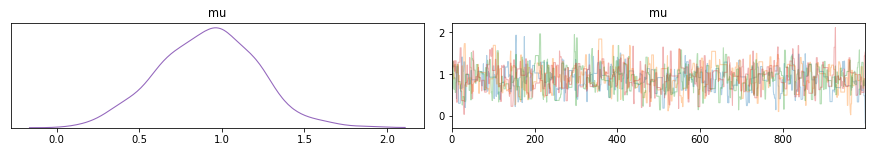

In [4]:
_ = pm.traceplot(trace, combined=True)

In [5]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.91,0.296,0.317,1.412,0.01,0.007,885.0,871.0,895.0,1053.0,1.01


## AutoCorrelation

This is a value between -1 and +1 and measures how linearly dependent a value in the Markov chain is to previous values (lags). Values close to 0 indicate a chain that has converged to the stationery distribution.

We can also look at the actual values using `np.corrcoef` between two slices of the trace, as [described on this StackOverflow page](https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation).

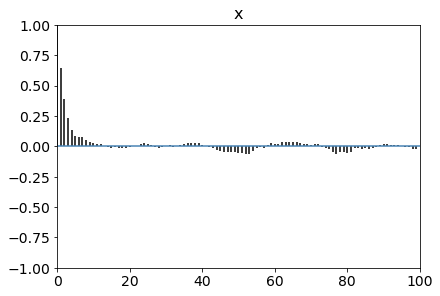

In [6]:
_ = pm.autocorrplot(trace["mu"], combined=True)

In [7]:
def autocorr(x, t=10):
    return np.corrcoef(np.array([x[:-t], x[t:]]))[0,1]

mu = trace.get_values("mu", chains=[2])
print("Autocorrelation over entire chain:    {:.5f}".format(autocorr(mu)))
print("Autocorrelation over first 100 steps: {:.5f}".format(autocorr(mu[0:100])))
print("Autocorrelation over last 100 steps:  {:.5f}".format(autocorr(mu[-100:])))

Autocorrelation over entire chain:    0.02603
Autocorrelation over first 100 steps: 0.10111
Autocorrelation over last 100 steps:  0.17938


Another strategy to increase the auto-correlation in a chain is to increase the lag. Here we compute the autocorrelation values over the chain with lag set to 4 times the default.

In [8]:
print("Autocorrelation over entire chain (t=40): {:.5f}".format(autocorr(trace["mu"], t=40)))

Autocorrelation over entire chain (t=40): 0.00791


## Effective Sample Size

Effective sample size is a measure of how many independent samples from the stationery distribution is needed to get equivalent information from the Markov Chain. Prior to convergence, the effective sample size is usually much smaller than the actual sample size, while during convergence, the effective sample size should be almost equal to the actual sample size.

See the [Using PyMC3](http://people.duke.edu/~ccc14/sta-663-2018/notebooks/S11A_PyMC3.html) for this and other measures (covered below) of useful measures of convergence.

Here we see that the effective sample size for `mu` is 894, which is fairly close to actual `n_iter`=1000.

In [9]:
pm.effective_n(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 894.9

In [10]:
pm.ess(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 894.9

## Raftery and Lewis Diagnostic

Generally, trying to predict the mean and standard deviation of the posterior distribution(s) is a simpler problem compared to finding quantiles or confidence intervals of the posterior distribution. Problems of the latter kind require a large number of samples. The Raftery and Lewis Diagnostic provides an estimate of sample size required to estimate variables of this kind.

Unfortunately, this function was available in PyMC 2.x but seems to be deprecated for PyMC3. Call below returns the sample size needed to predict the sample size required to predict the 95% interval (q=0.025 is lower limit) with 1% error (r=0.01) and 95% confidence (s=0.95). See this [page on PyMC model checking](https://pymc-devs.github.io/pymc/modelchecking.html) for more details.

    pm.raftery_lewis(trace["mu"], q=0.025, r=0.01, s=0.95)

## Gelman-Rubin Diagnostic

The Gelman-Rubin diagnostic compares the variability within chains with the variability across chains for multiple Markov chains started with different initial parameters. Values of this diagnostic close to 1 indicate convergence.

In [11]:
pm.gelman_rubin(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.007

## Reference

Interesting article [Hands on Bayesian Statistics with Python, PyMC3, and Arviz](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501) by Susan Li, who puts some of these ideas together to solve a real world problem.